<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/timit_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install soundfile

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import zipfile

zipfile.ZipFile('My Drive/darpa-timit-acousticphonetic-continuous-speech.zip').extractall('..')

In [0]:
from pathlib import Path
import soundfile as sf 
from tqdm.auto import tqdm

def read_speech(base):
  signals = []
  targets = []
  base = Path(base)
  for accent in tqdm(base.iterdir()):
    for speaker in accent.iterdir():
      for f in speaker.iterdir():
        if f.suffix == '.wav':
          signal, rate = sf.read(f)
          signals.append(signal)

          target_file = f.name.replace('.WAV.wav', '.TXT')
          target_path = speaker / target_file
          words = open(target_path).read().strip().split(' ')[2:]
          target = ' '.join(words).lower().replace('.', '').replace(',', '').replace(' -- ', ' ').replace('-', ' ').replace('?', '').replace('"', '').replace('!', '').replace(':', '').replace(';', '')
          targets.append(target)
  return signals, targets


In [5]:
import torch
import torch.nn as nn
import librosa
import numpy as np
from tqdm.auto import trange, tqdm


class SpeechData(torch.utils.data.Dataset):
  def __init__(self, inputs, input_lengths, outputs, output_lengths):
    self.inputs = inputs
    self.input_lengths = torch.Tensor(input_lengths)
    self.outputs = outputs
    self.output_lengths = torch.Tensor(output_lengths)
    
    self.n = len(inputs)
  
  def __len__(self):
    return self.n
  
  def __getitem__(self, i):
    inp = self.inputs[i]
    inp_len = self.input_lengths[i]
    op = self.outputs[i]
    op_len = self.output_lengths[i]
    return inp, inp_len, op, op_len

#
# Training data
#
s, t = read_speech('../data/TRAIN')
chars = set(''.join(t))
char2index = { c: i+2 for i, c in enumerate(chars) }
char2index['<'] = 0
char2index['>'] = 1
print (char2index)

inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y in tqdm(zip(s, t), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 

train_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


#
# Test data
#
s, t = read_speech('../data/TEST')
inputs = []
input_lengths =[]
outputs = []
output_lengths = []
for x, y in tqdm(zip(s, t), total=len(s)):
  inp = torch.from_numpy(np.abs(librosa.stft(x, n_fft=1024, hop_length=512)).T)
  inputs.append(inp)
  input_lengths.append(len(inp))

  output = torch.Tensor([char2index[c] for c in '<' + y + '>'])
  outputs.append(output)
  output_lengths.append(len(output)) 
test_data = SpeechData(inputs, input_lengths, outputs, output_lengths)


{'w': 2, "'": 3, 'n': 4, 'o': 5, 'j': 6, 'v': 7, 'i': 8, ' ': 9, 'g': 10, 'b': 11, 'y': 12, 'l': 13, 'e': 14, 'p': 15, 'u': 16, 'h': 17, 'q': 18, 'z': 19, 'a': 20, 'm': 21, 'r': 22, 't': 23, 'c': 24, 'k': 25, 's': 26, 'd': 27, 'x': 28, 'f': 29, '<': 0, '>': 1}


In [0]:
class SpeechNet(nn.Module):
  def __init__(self, device, input_size=513, output_size=len(char2index)+1, num_layers=2, hidden_size=256):
    self.device = device
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    super(SpeechNet, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    output, (h, c) = self.lstm(x, (h,c))
    # print (h.shape, c.shape)
    out = self.linear(output)
    return torch.nn.functional.log_softmax(out, 2)
  

def collate(batch):
  inp, inp_len, op, op_len = zip(*batch)
  inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=len(char2index))
  inp_len = torch.stack(inp_len)
  op = torch.cat(op) # torch.nn.utils.rnn.pad_sequence(op, batch_first=True, padding_value=len(char2index))
  op_len = torch.stack(op_len)
  return inp, inp_len, op, op_len 


import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, collate_fn=collate)

In [28]:
from torch.autograd import Variable
from tqdm.auto import tqdm
import itertools

from torch.optim.lr_scheduler import ExponentialLR
device = torch.device('cuda')

net = SpeechNet(device).to(device)
net.apply(weight_init)


clip_value = 1.0
criterion = nn.CTCLoss(blank=len(char2index), zero_infinity=True, reduction='none').to(device) 
optimizer = torch.optim.Adam(net.parameters(), weight_decay=0.001)

scheduler = ExponentialLR(optimizer, gamma=0.9999)

losses = []
test_loss = []
for epoch in range(25):
  print (f'Epoch {epoch}:')
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
    op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 400)
    
    optimizer.step()
    scheduler.step()
  print ('train loss = ', np.mean(losses[::-1][:len(train_loader)]))
  
  
  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(test_loader):
        
        inp, inp_len = Variable(inp.float()).to(device), Variable(inp_len.long()).to(device)
        op, op_len = Variable(op.long()).to(device), Variable(op_len.long()).to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        test_loss.append(loss.item())
    print ('test loss = ', np.mean(test_loss[::-1][:len(test_loader)]))

    '''
    index2char = dict(zip(char2index.values(), char2index.keys()))
    for pi in p:
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        if i < len(index2char):
          print (index2char[i], end = '')
      print ()
    '''

Epoch 0:


train loss =  150.78830750347817


test loss =  144.28574456108942
Epoch 1:


train loss =  139.61318969726562


test loss =  133.3109359741211
Epoch 2:


train loss =  122.0646580735298


test loss =  110.17134263780382
Epoch 3:


train loss =  102.02551039604292


test loss =  95.65344125253183
Epoch 4:


train loss =  89.77172893367401


test loss =  86.72284783257379
Epoch 5:


train loss =  82.43984640461125


test loss =  80.78694703843858
Epoch 6:


train loss =  77.80197786305048


test loss =  79.4300958138925
Epoch 7:


train loss =  74.24913280957365


test loss =  77.27208088062427
Epoch 8:


train loss =  71.63769625311028


test loss =  75.69181484646268
Epoch 9:


train loss =  68.43322356759685


test loss =  72.46692756370261
Epoch 10:


train loss =  65.71178995419855


test loss =  73.21191519278067
Epoch 11:


train loss =  64.00795134452925


test loss =  71.76594388043439
Epoch 12:


train loss =  61.859108546008805


test loss =  71.1553709242079
Epoch 13:


train loss =  59.775606129267445


test loss =  70.83692734329789
Epoch 14:


train loss =  57.65661908502448


test loss =  69.9426515367296
Epoch 15:


train loss =  56.13714839987559


test loss =  70.42572233412001
Epoch 16:


train loss =  54.190735490354776


test loss =  69.89396625094943
Epoch 17:


train loss =  52.21620402924002


test loss =  71.04115634494357
Epoch 18:


train loss =  50.62433598139515


test loss =  70.66162024603949
Epoch 19:


train loss =  48.704351973860234


test loss =  70.7885198239927
Epoch 20:


train loss =  47.05838916726308


test loss =  72.07297445226598
Epoch 21:


train loss =  45.30481233988723


test loss =  72.65917573151765
Epoch 22:


train loss =  44.05817099793317


test loss =  73.26764014915183
Epoch 23:


train loss =  42.433730190747404


test loss =  73.80245321768301
Epoch 24:


train loss =  40.34091766566446


test loss =  74.20252891823098


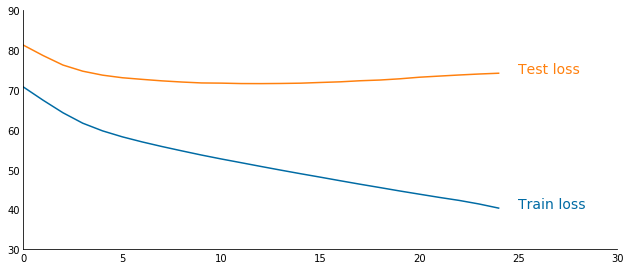

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

index2char = dict(zip(char2index.values(), char2index.keys()))

plt.figure(figsize=(10,5))
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)


tr = [np.mean(losses[start:start+len(losses)])  for start in range(0, len(losses), len(train_loader))]
plt.plot(tr, color=tableau20blind[0])


te = [np.mean(test_loss[start:start+len(test_loss)]) for start in range(0, len(test_loss), len(test_loader))]

plt.xlim(0, len(tr)+5)
plt.plot(te, color=tableau20blind[1])

plt.text( len(tr),tr[-1],   'Train loss', color=tableau20blind[0], fontsize=14)
plt.text( len(te),te[-1], 'Test loss', color=tableau20blind[1], fontsize=14)

plt.ylim(30, 90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout(pad=5)
plt.gca().tick_params(axis='both', length=0)

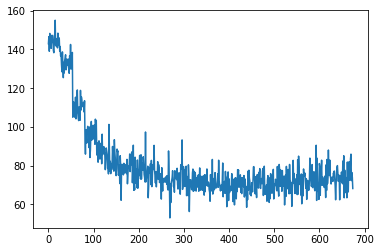

In [30]:
plt.plot(test_loss)

In [36]:
import itertools
index2char = dict(zip(char2index.values(), char2index.keys()))
with torch.no_grad():
  for inp, inp_len, op, op_len in test_loader:
      
    inp, inp_len = inp.float().to(device), inp_len.long().to(device)
    op, op_len = op.long().to(device), op_len.long().to(device)

      

    p = net(inp)
    start = 0
    for pi, o in zip(p, op_len):
      
      
      print (''.join(index2char[i] for i in op[start:start+o].cpu().numpy()))
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        
        if i < len(index2char):
          print (index2char[i], end = '')
      print ('\n')
      start += o
    break

<only lawyers love millionaires>
<otme loryers love nein harers>

<artificial intelligence is for real>
<ar is fichiol ind telicgincs isfor rel>

<don't ask me to carry an oily rag like that>
<tdon't ask me to carry an oily rag like that>

<if people were more generous there would be no need for welfare>
<hit puo l or morge ers the rbeng non heed fo walth har>

<she had your dark suit in greasy wash water all year>
<she ad your dark suit in greasy wash water all year>

<widow nice sort of woman>
<we evi mace sortet a man

<they took it away overalls or something>
<thit docat awath bovor als resomtaing>

<tradition requires parental approval for under age marriage>
<coition ere quirs protl a proval for nderateen narige>

<a boring novel is a superb sleeping pill>
<abooryng notlthis es sepperbslacing ta>

<otherwise you may be saddled with a good size milk bill by milk drinkers>
<ohor waes our maebe scatawithay good saes mnotp> the bannot>trengrs> 

<she had your dark suit in greasy wash